# Atividade • Data Science
<hr>

## Data Discovery

### Sumário

<p> Número de clientes: 105,508

Número de produtos: 5,850

Número de transações: 192,544 </p>


### Dicionário

- **item_id:** ID exclusivo do produto

- **weight:** medição de peso do cliente

- **rented for:** roupas para esse fim que foram alugadas para

- **body type:** tipo de corpo do cliente

- **review_text:** avaliação dada pelo cliente

- **review_summary:** resumo da avaliação

- **size:** o tamanho padronizado do produto

- **rating:** classificação do produto

- **age:** idade do cliente

- **category:** a categoria do produto

- **bust size:** medição do busto do cliente

- **height:** altura do cliente

- **fit:** ajuste de feedback

- **user_id:** um ID exclusivo para o cliente

- **review_date**: data em que a resenha foi escrita

## Objetivos
<p>1. Produza um gráfico da distribuição de peso (histograma) dos clientes (<strong>em Kg</strong>)</p>
<p>2. Qual motivo de aluguel (“rented for”) tem o maior número absoluto de “fits”?  Quantos “fits” há para este motivo de aluguel?</p>
<p>3. Qual motivo de aluguel (“rented for”) tem o maior número relativo de “fits”? Qual é o percentual de “fits” para este motivo de aluguel?</p>
<p>4. Produza uma estatística de palavras mais usadas nas avaliações (“review_text”);</p>
<p>5. Que outra estatística ou insight você poderia extrair destes dados?</p>

## Preparando o Ambiente

### Distribuição Linux

In [533]:
! lsb_release -a

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 22.04.3 LTS
Release:	22.04
Codename:	jammy


### Versão do Python

In [534]:
! python -V

Python 3.10.12


### Instalando as libs

In [535]:
! pip install -r "../requirements.txt"

### Instalando o JDK

- Execute no terminal o seguinte comando:
  - ```sudo apt-get install openjdk-8-jdk-headless -qq > /dev/null```

In [536]:
! java -version

openjdk version "1.8.0_382"
OpenJDK Runtime Environment (build 1.8.0_382-8u382-ga-1~22.04.1-b05)
OpenJDK 64-Bit Server VM (build 25.382-b05, mixed mode)


### Download do Spark

In [1]:
import os
import subprocess

spark_directory = "../spark/spark-3.5.0-bin-hadoop3"

# Verifique se a pasta spark-3.5.0-bin-hadoop3 não existe
if not os.path.exists(spark_directory):
    # Se a pasta não existe, execute o comando wget para baixar o arquivo
    wget_command = "wget -q -P '../spark' 'https://archive.apache.org/dist/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz'"
    tar_xf = "tar xf '../spark/spark-3.5.0-bin-hadoop3.tgz' -C '../spark'"
    rm_rf = "rm -rf '../spark/spark-3.5.0-bin-hadoop3.tgz'"
    subprocess.run(wget_command, shell=True)
    subprocess.run(tar_xf, shell=True)
    subprocess.run(rm_rf, shell=True)

### Importando as bibliotecas

In [540]:
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType, IntegerType, FloatType
from pyspark.sql import functions as f
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import HashingTF
from pyspark.ml.feature import IDF
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from wordcloud import WordCloud
from textblob import TextBlob
import matplotlib.pyplot as plt
import math

### Instanciando o Spark

In [541]:
! export JAVA_HOME=$(readlink -f $(which java))
! export SPARK_HOME="$(readlink -f ../)/spark/spark-3.5.0-bin-hadoop3"

In [542]:
import findspark
findspark.init()

In [543]:
spark = SparkSession.builder\
                    .appName("Atividade Data Science - Multiplan")\
                    .getOrCreate()

23/10/24 14:42:49 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [544]:
spark

## Lendo o arquivo

### Describe

In [545]:
df = spark.read.json('../data/raw/renttherunway_final_data.json')

In [546]:
df.printSchema()

root
 |-- age: string (nullable = true)
 |-- body type: string (nullable = true)
 |-- bust size: string (nullable = true)
 |-- category: string (nullable = true)
 |-- fit: string (nullable = true)
 |-- height: string (nullable = true)
 |-- item_id: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- rented for: string (nullable = true)
 |-- review_date: string (nullable = true)
 |-- review_summary: string (nullable = true)
 |-- review_text: string (nullable = true)
 |-- size: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- weight: string (nullable = true)



In [547]:
df.show(n=10)

+---+-----------------+---------+--------+---+------+-------+------+-------------+------------------+--------------------+--------------------+----+-------+------+
|age|        body type|bust size|category|fit|height|item_id|rating|   rented for|       review_date|      review_summary|         review_text|size|user_id|weight|
+---+-----------------+---------+--------+---+------+-------+------+-------------+------------------+--------------------+--------------------+----+-------+------+
| 28|        hourglass|      34d|  romper|fit| 5' 8"|2260466|    10|     vacation|    April 20, 2016|So many compliments!|An adorable rompe...|  14| 420272|137lbs|
| 36|straight & narrow|      34b|    gown|fit| 5' 6"| 153475|    10|        other|     June 18, 2013|I felt so glamour...|I rented this dre...|  12| 273551|132lbs|
|116|             NULL|     NULL|  sheath|fit| 5' 4"|1063761|    10|        party| December 14, 2015|It was a great ti...|This hugged in al...|   4| 360448|  NULL|
| 34|           

In [548]:
df.summary().show()

+-------+------------------+-----------------+------------------+--------+------+------+------------------+------------------+----------+-----------------+-------------------+--------------------+------------------+-----------------+------+
|summary|               age|        body type|         bust size|category|   fit|height|           item_id|            rating|rented for|      review_date|     review_summary|         review_text|              size|          user_id|weight|
+-------+------------------+-----------------+------------------+--------+------+------+------------------+------------------+----------+-----------------+-------------------+--------------------+------------------+-----------------+------+
|  count|            191584|           177907|            174133|  192544|192544|191867|            192544|            192462|    192534|           192544|             192544|              192544|            192544|           192544|162562|
|   mean|33.871017412727575|        

In [549]:
df = df\
    .withColumn('rating', df['rating'].cast(DoubleType()))

In [550]:
df.printSchema()

root
 |-- age: string (nullable = true)
 |-- body type: string (nullable = true)
 |-- bust size: string (nullable = true)
 |-- category: string (nullable = true)
 |-- fit: string (nullable = true)
 |-- height: string (nullable = true)
 |-- item_id: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- rented for: string (nullable = true)
 |-- review_date: string (nullable = true)
 |-- review_summary: string (nullable = true)
 |-- review_text: string (nullable = true)
 |-- size: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- weight: string (nullable = true)



### Identificando valores nulos

In [551]:
df.select([f.count(f.when(f.isnull(c), 1)).alias(c) for c in df.columns]).show()

+---+---------+---------+--------+---+------+-------+------+----------+-----------+--------------+-----------+----+-------+------+
|age|body type|bust size|category|fit|height|item_id|rating|rented for|review_date|review_summary|review_text|size|user_id|weight|
+---+---------+---------+--------+---+------+-------+------+----------+-----------+--------------+-----------+----+-------+------+
|960|    14637|    18411|       0|  0|   677|      0|    82|        10|          0|             0|          0|   0|      0| 29982|
+---+---------+---------+--------+---+------+-------+------+----------+-----------+--------------+-----------+----+-------+------+




## 1. Produza um gráfico da distribuição de peso (histograma) dos clientes (<strong>em Kg</strong>)

### Criar um dataframe sem valores nulos

In [552]:
df_1 = df.filter(f.col("weight").isNotNull())

In [553]:
df_1.select([f.count(f.when(f.isnull(c), 1)).alias(c) for c in df.columns]).show()

+---+---------+---------+--------+---+------+-------+------+----------+-----------+--------------+-----------+----+-------+------+
|age|body type|bust size|category|fit|height|item_id|rating|rented for|review_date|review_summary|review_text|size|user_id|weight|
+---+---------+---------+--------+---+------+-------+------+----------+-----------+--------------+-----------+----+-------+------+
|353|     8675|    10831|       0|  0|   444|      0|    57|        10|          0|             0|          0|   0|      0|     0|
+---+---------+---------+--------+---+------+-------+------+----------+-----------+--------------+-----------+----+-------+------+



### Criando a coluna de conversão para KG

In [554]:
lbs_to_kg = 0.45359237

In [555]:
df_1 = df_1\
    .withColumn("weight_kg", (f.regexp_replace(f.col("weight"), "lbs", "").cast("double") * lbs_to_kg))\
    .withColumn("weight_kg", f.round(f.col("weight_kg"), 2))\
    .select("user_id", "weight_kg")\
    .distinct()

In [556]:
df_1.show(n=10)

+-------+---------+
|user_id|weight_kg|
+-------+---------+
| 533900|    61.23|
| 804645|    86.18|
| 231198|    58.97|
| 689043|    66.22|
| 401869|    54.43|
|  36473|    65.77|
| 135002|    70.31|
| 450585|    65.77|
| 451613|     63.5|
|  23201|    47.63|
+-------+---------+
only showing top 10 rows



In [557]:
df_1 = df_1.pandas_api()

23/10/24 14:43:22 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [558]:
df_1.head()

,user_id,weight_kg
0,533900,61.23
1,804645,86.18
2,231198,58.97
3,689043,66.22
4,401869,54.43


/home/dgamorim/development/multiplan-data-science/.venv/lib/python3.10/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


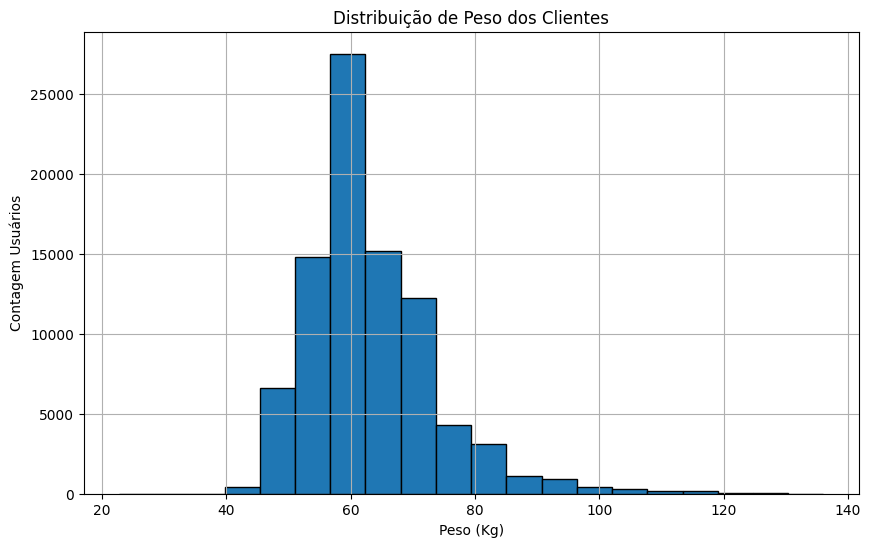

In [559]:
plt.figure(figsize=(10, 6))
plt.hist(df_1["weight_kg"], bins=20, edgecolor="k")
plt.title("Distribuição de Peso dos Clientes")
plt.xlabel("Peso (Kg)")
plt.ylabel("Contagem Usuários")
plt.grid(True)
plt.show()

## 2. Qual motivo de aluguel (“rented for”) tem o maior número absoluto de “fits”?  Quantos “fits” há para este motivo de aluguel?

In [560]:
df_2 = df.select('rented for', 'fit')

In [561]:
df_2 = df_2.filter(df["fit"] == "fit")

In [562]:
df_2 = df_2.filter(f.col("rented for").isNotNull())

In [563]:
df_2 = df_2\
    .groupBy("rented for")\
    .agg({"fit": "count"})

In [564]:
df_2 = df_2.orderBy(f.col("count(fit)").desc())

In [565]:
df_2.show(20)

+---------------+----------+
|     rented for|count(fit)|
+---------------+----------+
|        wedding|     43111|
|  formal affair|     31089|
|          party|     25874|
|       everyday|     11608|
|          other|     11334|
|           work|     10857|
|           date|      5261|
|       vacation|      2914|
|party: cocktail|         1|
+---------------+----------+



In [566]:
df_2 = df_2.first()

In [567]:
print("Aluguel que tem maior número de 'fit':", df_2["rented for"])
print(f"Quantidade de 'fit' para o aluguel {df_2['rented for']}: {df_2['count(fit)']}")

Aluguel que tem maior número de 'fit': wedding
Quantidade de 'fit' para o aluguel wedding: 43111


## 3. Qual motivo de aluguel (“rented for”) tem o maior número relativo de “fits”? Qual é o percentual de “fits” para este motivo de aluguel?

In [568]:
df_3 = df.select('rented for', 'fit')

In [569]:
df_3 = df_3.filter(df["fit"] == "fit")

In [570]:
df_3 = df_3.filter(f.col("rented for").isNotNull())

In [571]:
df_3 = df_3\
    .groupBy("rented for")\
    .agg({"fit": "count"})

In [572]:
df_3 = df_3.orderBy(f.col("count(fit)").desc())

In [573]:
max_abs_count = df_3.agg({"count(fit)": "sum"}).collect()[0]["sum(count(fit))"]

In [574]:
def calculate_relative_number(number):
    biggest_order = 10 ** int(math.log10(number))
    relative_number = int(biggest_order * round(number / biggest_order))
    return relative_number

In [575]:
udf_calculate = f.udf(calculate_relative_number, IntegerType())

In [576]:
df_3 = df_3.\
    withColumn("relative_number", udf_calculate(df_3["count(fit)"]))

In [577]:
df_3.show(20)

+---------------+----------+---------------+
|     rented for|count(fit)|relative_number|
+---------------+----------+---------------+
|        wedding|     43111|          40000|
|  formal affair|     31089|          30000|
|          party|     25874|          30000|
|       everyday|     11608|          10000|
|          other|     11334|          10000|
|           work|     10857|          10000|
|           date|      5261|           5000|
|       vacation|      2914|           3000|
|party: cocktail|         1|              1|
+---------------+----------+---------------+



In [578]:
df_3 = df_3.first()

In [579]:
print("Aluguel que tem maior número relativo de 'fit':", df_3["rented for"])
print(f"Percentual de 'fit' para o aluguel {df_3['rented for']}: {((df_3['count(fit)'] / max_abs_count) * 100):.2f}%")

Aluguel que tem maior número relativo de 'fit': wedding
Percentual de 'fit' para o aluguel wedding: 30.35%


## 4. Produza uma estatística de palavras mais usadas nas avaliações (“review_text”)

In [580]:
df_4 = df.select('review_text')

In [581]:
df_4 = df_4.filter(f.col("review_text").isNotNull())

In [582]:
df_4 = df_4\
    .withColumn("review_text_rgx", f.regexp_replace("review_text", "[\$#,\"!%&'()*+-./:;<=>?@^_`´{|}~\\\\]", ""))

In [583]:
df_4 = df_4\
    .withColumn("review_text_clean", f.trim(df_4.review_text_rgx))

In [584]:
stop_words = StopWordsRemover(inputCol="words", outputCol="filtered_words")

In [585]:
df_4 = df_4\
    .withColumn("words", f.split(df_4["review_text_clean"], " "))

In [586]:
df_4.show(n=5)

+--------------------+--------------------+--------------------+--------------------+
|         review_text|     review_text_rgx|   review_text_clean|               words|
+--------------------+--------------------+--------------------+--------------------+
|An adorable rompe...|An adorable rompe...|An adorable rompe...|[An, adorable, ro...|
|I rented this dre...|I rented this dre...|I rented this dre...|[I, rented, this,...|
|This hugged in al...|This hugged in al...|This hugged in al...|[This, hugged, in...|
|I rented this for...|I rented this for...|I rented this for...|[I, rented, this,...|
|I have always bee...|I have always bee...|I have always bee...|[I, have, always,...|
+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [587]:
df_4 = stop_words.transform(df_4)

In [588]:
df_4.select("filtered_words").show(truncate=False, n=5)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|filtered_words                                                                                                                                                                                                                                                                                                                                                                                        |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [589]:
df_4 = df_4\
    .select(f.explode(df_4["filtered_words"]).alias("words"))

In [590]:
df_4 = df_4\
    .withColumn("words", f.trim(df_4['words']))

In [591]:
df_4 = df_4\
    .withColumn("words", f.regexp_replace(df_4["words"], "^n", ""))

In [592]:
df_4 = df_4\
    .filter(f.col("words") != "")

In [593]:
df_4 = df_4\
    .groupBy("words").agg(f.count("words").alias("count"))

### TOP 5 - Words

In [594]:
df_4.orderBy(f.desc("count")).show(n=5)

+------+------+
| words| count|
+------+------+
| dress|250798|
|   fit| 85201|
|  size| 77116|
|  wear| 62792|
|little| 54713|
+------+------+
only showing top 5 rows



### Wordcloud

In [595]:
words_list = [word['words'] for word in df_4.collect()]

In [596]:
wordcloud = WordCloud(background_color = 'black',
                      width = 1000,
                      height = 600,
                      collocations = False, 
                      prefer_horizontal = 1).generate(str(words_list))

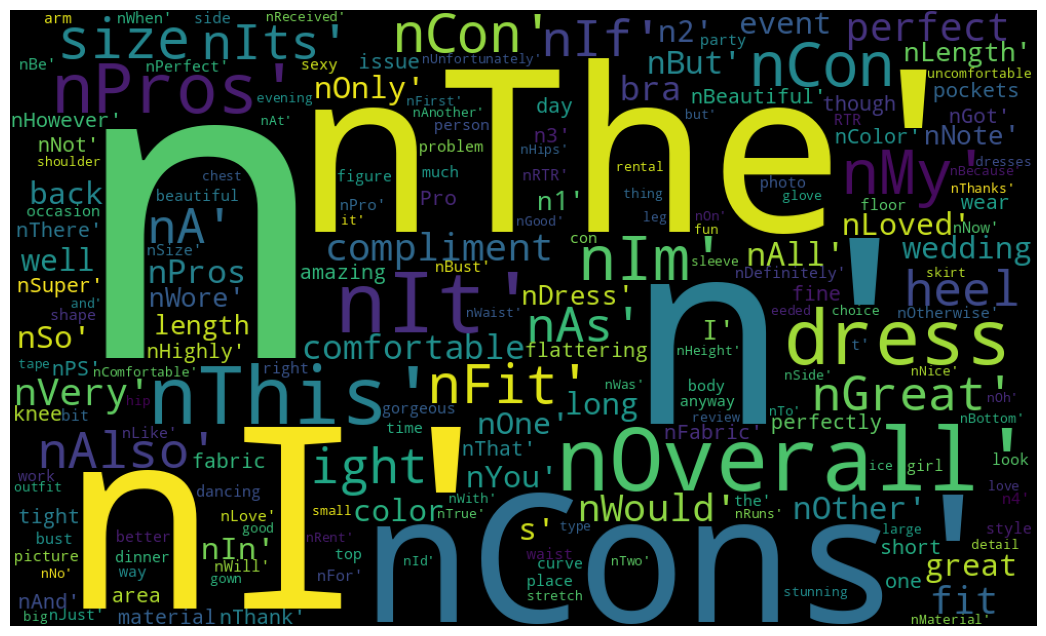

In [597]:
plt.figure(figsize=(20,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## 5. Que outra estatística ou insight você poderia extrair destes dados?

> **Objetivo** : Construir um modelo de machine learning para prever a polaridade do review_text. Desta forma conseguimos analisar se ela é uma mensagem positiva ou negativa.

### Pré processamento

In [598]:
df_5 = df.select('review_text')

In [599]:
df_5 = df_5.filter(f.col("review_text").isNotNull())

In [600]:
df_5.show(truncate=False, n=20)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|review_text                                                                                                                                                                                                                                    

In [601]:
df_5 = df_5\
    .withColumn("review_text_rgx", f.regexp_replace("review_text", "[\$#,\"!%&'()*+-./:;<=>?@^_`´{|}~\\\\]", ""))

In [602]:
df_5.show(truncate=False, n=20)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [603]:
df_5 = df_5\
    .withColumn("review_text_clean", f.trim(df_5.review_text_rgx))

In [604]:
df_5.show(truncate=False, n=20)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [605]:
def sentiment_analyzer(text: str):
    analysis = TextBlob(text)
    polarity = float(analysis.sentiment.polarity)
    if (polarity < 0):
        return -1
    elif (polarity >= 0) & (polarity < 0.6):
        return 0
    else:
        return 1

def subjectivity_analyzer(text: str):
    analysis = TextBlob(text)
    return round(analysis.sentiment.subjectivity * 100,2)

In [606]:
udf_sentiment_analyzer = f.udf(sentiment_analyzer, IntegerType())
udf_subjectivity_analyzer = f.udf(subjectivity_analyzer, FloatType())

In [607]:
df_5 = df_5\
    .withColumn("sentiment", udf_sentiment_analyzer(df_5['review_text_clean']))\
    .withColumn("subjectivity", udf_subjectivity_analyzer(df_5['review_text_clean']))

> **Polaridade (Polarity)**: A polaridade é uma medida que indica o quão positivo, negativo ou neutro é o texto. Ela varia de -1 a 1, onde -1 representa um sentimento negativo, 1 representa um sentimento positivo e 0 representa um sentimento neutro.

> **Subjetividade (Subjectivity)**: A subjetividade é uma medida que indica o quão objetivo ou subjetivo é o texto. Ela varia de 0 a 1, onde 0 representa um texto altamente objetivo (fatos, informações) e 1 representa um texto altamente subjetivo (opiniões, sentimentos).

In [608]:
df_5 = df_5.filter(df_5["sentiment"] != 0)

In [609]:
df_5.show(n=20)

+--------------------+--------------------+--------------------+---------+------------+
|         review_text|     review_text_rgx|   review_text_clean|sentiment|subjectivity|
+--------------------+--------------------+--------------------+---------+------------+
|I have always bee...|I have always bee...|I have always bee...|       -1|       32.04|
|I was nervous of ...|I was nervous of ...|I was nervous of ...|        1|        77.5|
|The dress arrived...|The dress arrived...|The dress arrived...|       -1|       63.51|
|I wore this dress...|I wore this dress...|I wore this dress...|        1|       66.67|
|This dress fit pe...|This dress fit pe...|This dress fit pe...|        1|       71.67|
|The side zipper w...|The side zipper w...|The side zipper w...|       -1|       68.75|
|It fit me perfect...|It fit me perfect...|It fit me perfect...|        1|        70.0|
|The length was pe...|The length was pe...|The length was pe...|        1|       74.83|
|I normally wear a...|I normally

In [610]:
string_indexer = StringIndexer(inputCol="sentiment", outputCol="label")
df_5 = string_indexer.fit(df_5).transform(df_5)

In [611]:
df_5.groupBy(['sentiment','label']).count().show()

+---------+-----+-----+
|sentiment|label|count|
+---------+-----+-----+
|        1|  0.0| 9909|
|       -1|  1.0| 8386|
+---------+-----+-----+



In [612]:
tokenizer = Tokenizer(inputCol="review_text_clean", outputCol="tokens")
stopwords = StopWordsRemover(inputCol="tokens", outputCol="review_text_final")
hashingTF = HashingTF(inputCol=stopwords.getOutputCol(), outputCol="HTF", numFeatures=1000)
tfidf = IDF(inputCol="HTF", outputCol="features")


pipeline = Pipeline(stages = [tokenizer,stopwords, hashingTF, tfidf])

In [613]:
df_5_transform = pipeline.fit(df_5).transform(df_5)

In [614]:
df_5_transform.limit(5).show()

+--------------------+--------------------+--------------------+---------+------------+-----+--------------------+--------------------+--------------------+--------------------+
|         review_text|     review_text_rgx|   review_text_clean|sentiment|subjectivity|label|              tokens|   review_text_final|                 HTF|            features|
+--------------------+--------------------+--------------------+---------+------------+-----+--------------------+--------------------+--------------------+--------------------+
|I have always bee...|I have always bee...|I have always bee...|       -1|       32.04|  1.0|[i, have, always,...|[always, petite, ...|(1000,[11,37,59,7...|(1000,[11,37,59,7...|
|I was nervous of ...|I was nervous of ...|I was nervous of ...|        1|        77.5|  0.0|[i, was, nervous,...|[nervous, looking...|(1000,[137,190,21...|(1000,[137,190,21...|
|The dress arrived...|The dress arrived...|The dress arrived...|       -1|       63.51|  1.0|[the, dress, arri

### Modelo - Decision Tree

In [615]:
df_feature = df_5_transform.select(['features', 'label'])

In [616]:
df_feature.limit(5).show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|features          

In [617]:
df_feature.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



### Criando o pipeline para treinar o modelo

In [618]:
tokenizer = Tokenizer(inputCol="review_text_clean", outputCol="tokens")
stopwords = StopWordsRemover(inputCol="tokens", outputCol="review_text_final")
hashingTF = HashingTF(inputCol=stopwords.getOutputCol(), outputCol="HTF", numFeatures=1000)
tfidf = IDF(inputCol="HTF", outputCol="features")
dt = DecisionTreeClassifier(featuresCol='features', labelCol='label', maxDepth=10)

pipeline = Pipeline(stages = [tokenizer,stopwords, hashingTF, tfidf, dt])

### Amostra e Treino

In [619]:
train, test = df_5.randomSplit([0.7, 0.3], seed = 101)

In [620]:
dt_model = pipeline.fit(train)

In [621]:
predictions = dt_model.transform(test)

In [622]:
predictions.show(n=10)

+--------------------+--------------------+--------------------+---------+------------+-----+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+----------+
|         review_text|     review_text_rgx|   review_text_clean|sentiment|subjectivity|label|              tokens|   review_text_final|                 HTF|            features| rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+---------+------------+-----+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+----------+
| I am 5'6", 130 l...| I am 56 130 lbs ...|I am 56 130 lbs a...|        1|       75.62|  0.0|[i, am, 56, 130, ...|[56, 130, lbs, 36...|(1000,[31,161,314...|(1000,[31,161,314...| [2824.0,23.0]|[0.99192132068844...|       0.0|
| I am a 4 so it w...| I am a 4 so it w...|I am a 4 so it wa...|       -1|       26.92|  1.0|[i, am,

### Teste e Métricas

In [623]:
predictions.select(['label','prediction']).show(n=10)

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  1.0|       0.0|
|  1.0|       1.0|
+-----+----------+
only showing top 10 rows



In [624]:
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')

accuracy = evaluator.evaluate(predictions)

In [625]:
print(f"Acurácia = {(accuracy * 100):.2f}%")

Acurácia = 94.04%


### Realizando previsões

In [626]:
df_new = spark.createDataFrame([
    (1, "The jeans came torn on the side and are of poor quality. Did not like !"),
    (0, "I loved the shirt."),
], ["id","review_text_clean"])

In [627]:
new_class = dt_model.transform(df_new)

In [628]:
new_class.show()

+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+----------+
| id|   review_text_clean|              tokens|   review_text_final|                 HTF|            features| rawPrediction|         probability|prediction|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+----------+
|  1|The jeans came to...|[the, jeans, came...|[jeans, came, tor...|(1000,[103,156,16...|(1000,[103,156,16...|[253.0,4838.0]|[0.04969554115105...|       1.0|
|  0|  I loved the shirt.|[i, loved, the, s...|     [loved, shirt.]|(1000,[194,789],[...|(1000,[194,789],[...|  [676.0,32.0]|[0.95480225988700...|       0.0|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+----------+



In [629]:
spark.createDataFrame([
    (1, "Positive = 0"),
    (0, "Negative = 1"),
], ["id","prediction_dict"]).toPandas().head()

,id,prediction_dict
0,1,Positive = 0
1,0,Negative = 1
